# Documentation

**Bayesian Inference on MERRA-2 data**

**Spencer Ressel**

2023.02.07

This notebook will be used to perform Bayesian inference on data from the MERRA-2 reanalysis product: https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/

The inference will be performed to estimate the values of several parameters specified in Ahmed (2021). 

There are several dependencies for this notebook, including many standard python packages. Special packages for Bayesian inference include the *JAX* API (https://jax.readthedocs.io/en/latest/index.html) and the *numpyro* library (https://num.pyro.ai/en/latest/index.html). 
Additionally, the notebook imports the file *mjo_mean_state_diagnostics.py*, developed by Mu-Ting Chien and modified by Spencer Ressel, which contains a series of useful functions for evaluating and analyzing geophysical data relevant to the Madden-Julian Oscillation (MJO). 

# Imports

In [1]:
import numpy as np
import xarray as xr
from scipy.integrate import trapz
from scipy import signal

import mjo_mean_state_diagnostics as mjo

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors as mcolors

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# Specify constants

In [2]:
LONGITUDE_MIN = 60
LONGITUDE_MAX = 130

LATITUDE_SOUTH = -15
LATITUDE_NORTH = 15

PRESSURE_LOWER = 850
PRESSURE_UPPER = 200

LOWCUT = 1/100
HIGHCUT = 1/20

GRAVITY = 9.81        # m s^-2
WATER_DENSITY = 997   # kg m^-3

# Load data
The data are MERRA-2 netCDF files of:

* Specific Humidity
* Temperature
* Zonal Wind Velocity
* Meridional Wind Velocity
* Vertical Pressure Velocity

The data is available from 1999-01-01 to 2018-12-31, on 25 pressure levels spanning 1000 hPa to 100 hPa, with zonally global 2.5°x2.5° spatial resolution in the tropics from 20°S to 20°N.

In [31]:
# Specify data location
data_folder = r"/home/disk/eos7/sressel/Research/Data/NASA/MERRA2/"

# Load specific humidity
file_name = r"merra2_data.nc"
data = xr.open_dataset(data_folder+file_name, engine="netcdf4")

# Variables to be column-integrated
specific_humidity = data['QV'].sel(
    lev = slice(PRESSURE_LOWER,PRESSURE_UPPER),
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))
column_water_vapor = -(1/GRAVITY)*specific_humidity.integrate(dim = 'lev')
column_water_vapor = column_water_vapor.rename('CWV')
column_water_vapor.attrs['units'] = 'kg m^-2'
column_water_vapor.attrs['long_name'] = 'Column Water Vapor'


temperature = data['T'].sel(
    lev = slice(PRESSURE_LOWER,PRESSURE_UPPER),
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))
column_temperature = -(1/GRAVITY)*temperature.integrate(dim = 'lev')
column_temperature = column_temperature.rename('CIT')
column_temperature.attrs['units'] = 'K kg m^-2'
column_temperature.attrs['long_name'] = 'Column Integrated Temperature'


# Variables that aren't
zonal_velocity = data['U'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)
meridional_velocity = data['V'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)
vertical_velocity = data['OMEGA'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)

longitude = data['lon'].sel(lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))
latitude = data['lat'].sel(lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH))
pressure_levels = data['lev'].sel(lev = slice(PRESSURE_LOWER, PRESSURE_UPPER))
column_integrated_pressure = -pressure_levels.integrate(dim='lev')
time = data['time']

variables_dict = {
    'column water vapor':column_water_vapor,
    'column temperature':column_temperature,
    'zonal velocity':zonal_velocity,
    'meridional velocity':meridional_velocity,
    'vertical velocity':vertical_velocity
}

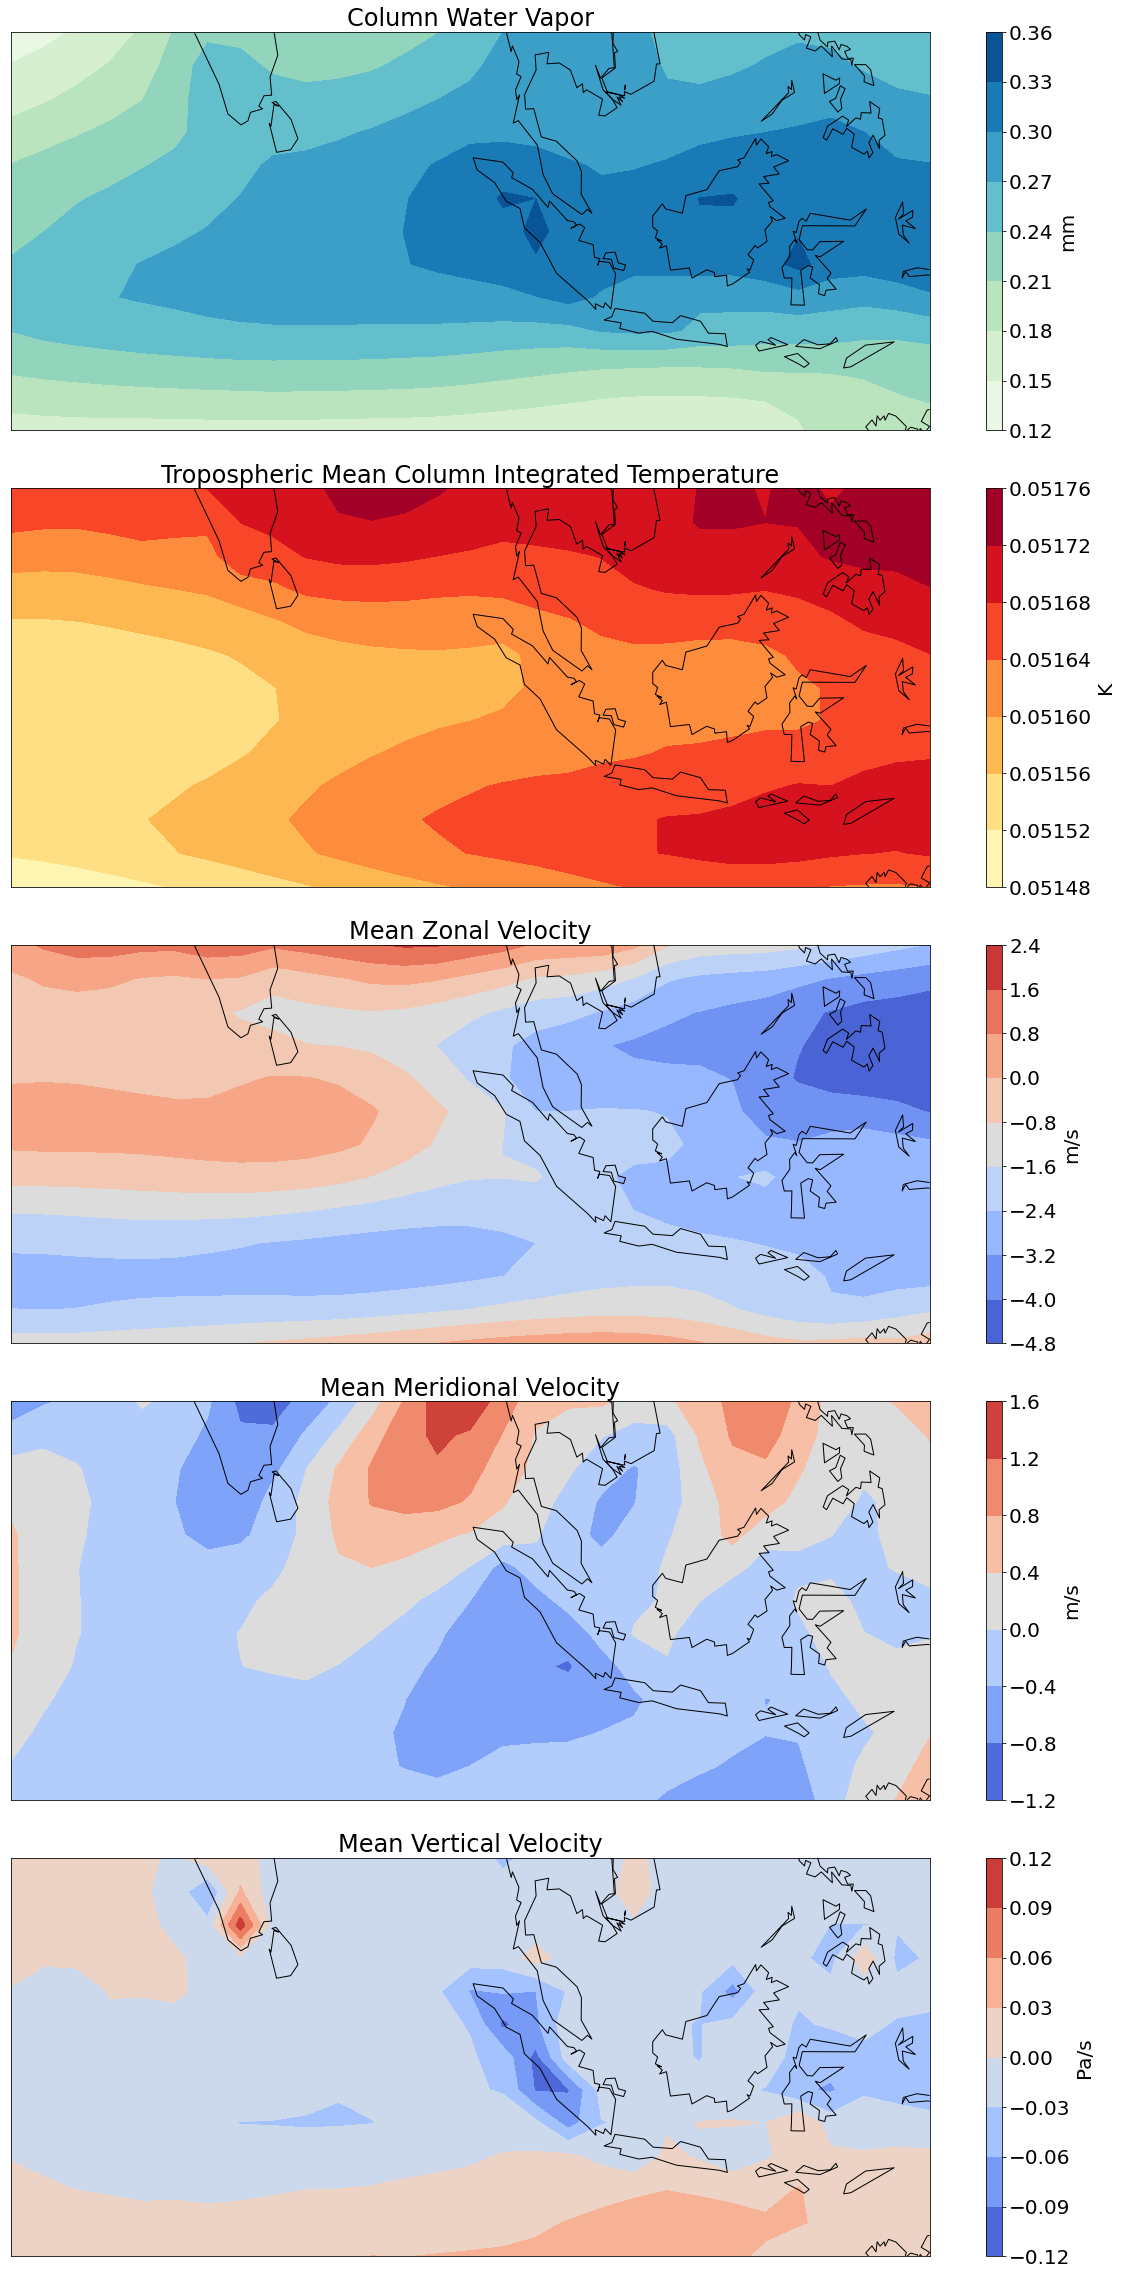

In [4]:
[longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(5, 1, figsize=(32, 32))

# Column Water Vapor
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[0])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[0].set_title('Column Water Vapor')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    (1000/WATER_DENSITY)*column_water_vapor.mean(dim='time'),
    cmap='GnBu', 
    latlon=True
)
cbar0 = fig.colorbar(cf, ax=ax[0], aspect=25, pad=0.025, orientation='vertical')
cbar0.set_label('mm')

# Column Temperature
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[1])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[1].set_title('Tropospheric Mean Column Integrated Temperature')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    column_temperature.mean(dim='time')/column_integrated_pressure,
    cmap='YlOrRd', 
    latlon=True
)
cbar1 = fig.colorbar(cf, ax=ax[1], aspect=25, pad=0.025, orientation='vertical')
cbar1.set_label('K')

# Zonal Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[2])
m.drawcoastlines()
# m.fillcontinents(color='white')
ax[2].set_title(f'Mean Zonal Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    zonal_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar2 = fig.colorbar(cf, ax=ax[2], aspect=25, pad=0.025, orientation='vertical')
cbar2.set_label('m/s')

# Meridional Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[3])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[3].set_title(f'Mean Meridional Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    meridional_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar3 = fig.colorbar(cf, ax=ax[3], aspect=25, pad=0.025, orientation='vertical')
cbar3.set_label('m/s')

# Vertical Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[4])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[4].set_title('Mean Vertical Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    vertical_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar4 = fig.colorbar(cf, ax=ax[4], aspect=25, pad=0.025, orientation='vertical')
cbar4.set_label('Pa/s')

plt.tight_layout()
plt.show()

# Data processing

## Detrend data in time

In [14]:
variables_detrended = {}

for variable in variables_dict:
    variables_detrended[variable] = variables_dict[variable].copy(deep=True)
    variables_detrended[variable].values = signal.detrend(variables_dict[variable], axis=0, type='linear')

## Remove the annual cycle and first three harmonics

In [27]:
variables_deannualized = {}
variables_annual_cycle = {}

# Column integrated variables
for variable in ['column water vapor', 'column temperature']:
    variables_deannualized[variable] = variables_detrended[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_detrended[variable].copy(deep=True)
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time=time, 
        lat=latitude,
        lon=longitude
    )    
    
for variable in ['zonal velocity', 'meridional velocity', 'vertical velocity']:
    variables_deannualized[variable] = variables_detrended[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_detrended[variable].copy(deep=True)
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time=time, 
        lev=pressure_levels, 
        lat=latitude,
        lon=longitude
    )    

## Filter the data for MJO signals

In [28]:
variables_filtered = {}
for variable in variables_dict:
    variables_filtered[variable] = variables_deannualized[variable].copy(deep=True)
    variables_filtered[variable].values = mjo.lanczos_bandpass_filter(
        variables_deannualized[variable],
        lowcut = LOWCUT,
        highcut = HIGHCUT,
        fs=1,
        filter_axis=0,
    )

## Select boreal winter points
Specifically November-March

In [110]:
YYYYMMDD_time = mjo.datetime64_to_yyyymmdd(time.values)
[year, month, day] = mjo.yyyymmdd_y_m_d(YYYYMMDD_time)
boreal_winter_indices = np.squeeze(np.where((month >= 11) | (month <= 3)))

In [41]:
variables_boreal_winter = {}
variables_boreal_winter_mean = {}
winter_months = [11,12,1,2,3,4]

for variable in variables_dict:
    variables_boreal_winter[variable] = variables_filtered[variable].copy(deep=True)
    variables_boreal_winter[variable] = variables_boreal_winter[variable].sel(
        time=time['time.month'].isin(winter_months))
    
    variables_boreal_winter_mean[variable] = variables_boreal_winter[variable].mean(dim='time')

## Compute vertical EOF structures
First flatten the data spatially, so it has shape (len(pressure_levels), len(latitude) x len(longitude))
Then the pressure levels will be the structure dimension, and latitude and longitude will be the sampling dimension. The first EOF will be the baroclinic mode of each of the variables over this region for the MJO

In [63]:
variables_flattened = {}
variables_array = np.empty((3*len(pressure_levels), len(latitude)*len(longitude)))

for variable in ['zonal velocity', 'meridional velocity', 'vertical velocity']:
    variables_flattened[variable] = np.reshape(
        variables_boreal_winter_mean[variable].values, 
        (
            len(pressure_levels),
            len(latitude)*len(longitude)
        )
    )

variables_array[:len(pressure_levels),:] = variables_flattened['zonal velocity']
variables_array[len(pressure_levels):2*len(pressure_levels),:] = variables_flattened['meridional velocity']
variables_array[2*len(pressure_levels):,:] = variables_flattened['vertical velocity']

## Compute the EOF of vertical velocity and then regress others onto that

In [130]:
[
    variables_EOF,
    variables_PC, 
    eigval, 
    eigval_explained_var, 
    eigval_err, 
    dof, 
    phi_0, 
    phi_L
    ] = mjo.eof(variables_flattened['vertical velocity'])

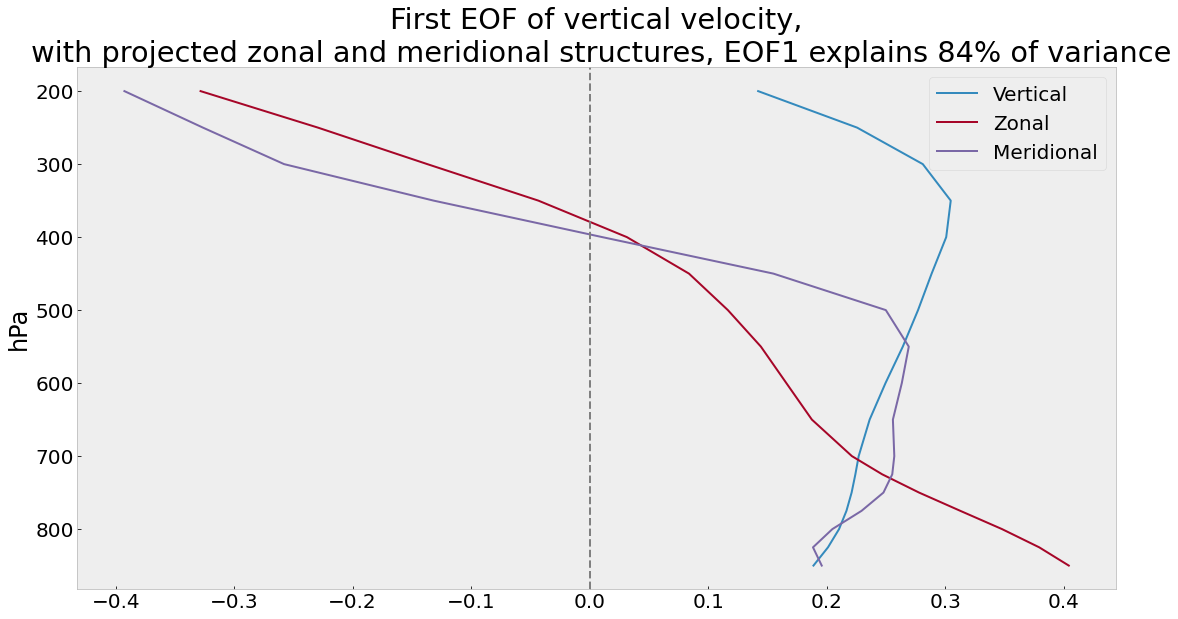

In [136]:
# Project zonal and meridional structures onto first EOF of vertical velocity
zonal_projection = np.einsum('ij, j->i', variables_flattened['zonal velocity'], (variables_PC[0]/np.std(variables_PC[0])))/377
meridional_projection = np.einsum('ij, j->i', variables_flattened['meridional velocity'], (variables_PC[0]/np.std(variables_PC[0])))/377


plt.style.use('bmh')
plt.figure(figsize=(16,9))
plt.title(
    'First EOF of vertical velocity,'
    + '\n with projected zonal and meridional structures,'
    + f' EOF1 explains {eigval_explained_var[0]:0.0f}% of variance')
plt.plot(-variables_EOF[0], pressure_levels, label='Vertical')
plt.plot(zonal_projection/np.linalg.norm(zonal_projection), pressure_levels, label='Zonal')
plt.plot(meridional_projection/np.linalg.norm(meridional_projection), pressure_levels, label='Meridional')
plt.axvline(0, ls='--', color='gray')
plt.ylabel('hPa')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

## Project data onto first EOF

In [117]:
variables_projected_vertically = {}

for variable in variables_dict:
    variables_projected_vertically[variable] = np.einsum(
        'j,ijkl->ikl', 
        variables_EOF[variable][0], 
        variables_filtered[variable]
    ) 

In [118]:
# [fig, ax] = plt.subplots(figsize=(20, 10))

# m = Basemap(projection='merc',lon_0=0, lat_0=0, llcrnrlat=-15,urcrnrlat=15,llcrnrlon=60,urcrnrlon=130)
# m.drawcoastlines()
# # m.fillcontinents(color='white')

# [longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

# cf = m.contourf(
#     longitude_mesh, 
#     latitude_mesh, 
#     variables_projected_vertically['zonal velocity'][1000], 
#     cmap='coolwarm', 
#     latlon=True,
#     levels=21
# )
# fig.colorbar(cf, ax=ax, aspect=50, pad=0.025, orientation='horizontal')

# plt.show()

In [119]:
single_location_data = {}

for variable in variables_dict:
    single_location_data[variable] = variables_projected_vertically[variable][:,8,10]

In [120]:
single_location_data['specific humidity']
moisture_tendency = np.gradient(single_location_data['specific humidity'], 1)

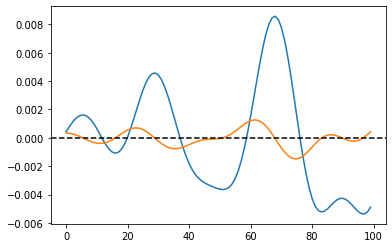

In [121]:
plt.figure()
plt.plot(single_location_data['specific humidity'][:100])
plt.plot(moisture_tendency[:100])
plt.axhline(y=0, color='k', ls='--')

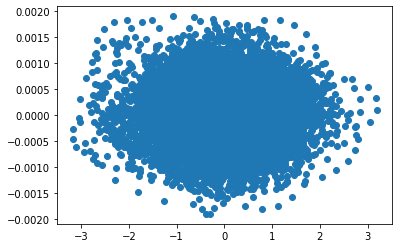

In [122]:
plt.scatter(single_location_data['temperature'], moisture_tendency)

## Project data onto meridional modes

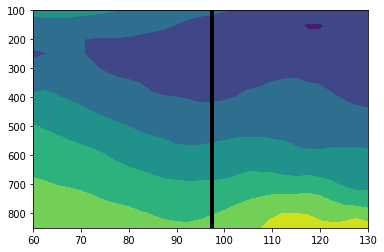

In [123]:
plt.figure()
plt.contourf(longitude, pressure_levels, variables_boreal_winter_mean['zonal velocity'][:,15,:])
plt.axvline(x=longitude[15], lw=4, color='k', zorder=10)
plt.gca().invert_yaxis()

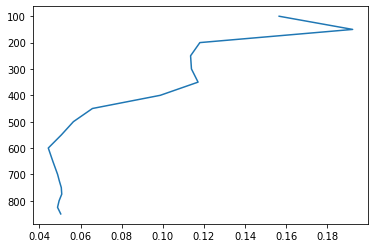

In [124]:
plt.figure()
plt.plot(variables_boreal_winter_mean['zonal velocity'][:,8,15], pressure_levels)
plt.gca().invert_yaxis()

In [125]:
longitude[0]

<xarray.DataArray 'lon' ()>
array(60.)
Coordinates:
    lon      float64 60.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [127]:
# [fig, ax] = plt.subplots(figsize=(20, 10))

# m = Basemap(projection='merc',lon_0=0, lat_0=0, llcrnrlat=-15,urcrnrlat=15,llcrnrlon=60,urcrnrlon=130)
# m.drawcoastlines()
# # m.fillcontinents(color='white')

# [longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

# cf = m.contourf(
#     longitude_mesh, 
#     latitude_mesh, 
#     variables_projected_vertically['meridional velocity'], 
#     cmap='coolwarm', 
#     latlon=True,
#     levels=21
# )
# fig.colorbar(cf, ax=ax, aspect=50, pad=0.025, orientation='horizontal')

# plt.show()

In [128]:
def model(u, v, y, omega, T, q, moisture_tendency):
    sigma_x = numpyro.sample('sigma_x', dist.Uniform(-10,10))
    sigma_y = numpyro.sample('sigma_y', dist.Uniform(-10,10))
    M_q = numpyro.sample('M_q', dist.LogNormal(0, 1.0))
    epsilon_q = numpyro.sample('epsilon_q', dist.LogNormal(0, 1.0))
    epsilon_t = numpyro.sample('epsilon_t', dist.LogNormal(0, 1.0))
    dqdt = numpyro.deterministic('dqdt', sigma_x*u - sigma_y*y*v - M_q*omega - epsilon_q*q + epsilon_t*T)
    
    numpyro.sample('obs', dist.Normal(dqdt), obs=moisture_tendency)

In [129]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model, adapt_step_size=True)
num_samples = 4000
mcmc = MCMC(kernel, num_chains=1, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key, 
    single_location_data['zonal velocity'],
    single_location_data['meridional velocity'],
    0,
    single_location_data['vertical velocity'],
    single_location_data['temperature'],
    single_location_data['specific humidity'],
    moisture_tendency
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|█| 5000/5000 [25:22<00:00,  3.28it/s, 1023 steps of size 3.87e-08.



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        M_q      0.51      0.00      0.51      0.51      0.51      0.50      1.00
  epsilon_q      2.45      0.00      2.45      2.45      2.45      0.50      1.00
  epsilon_t      5.48      0.00      5.48      5.48      5.48       nan       nan
    sigma_x      6.63      0.00      6.63      6.63      6.63      0.50      1.00
    sigma_y      7.47      0.00      7.47      7.47      7.47       nan       nan

Number of divergences: 0


/home/disk/p/sressel/.local/lib/python3.6/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


ValueError: cannot convert float NaN to integer

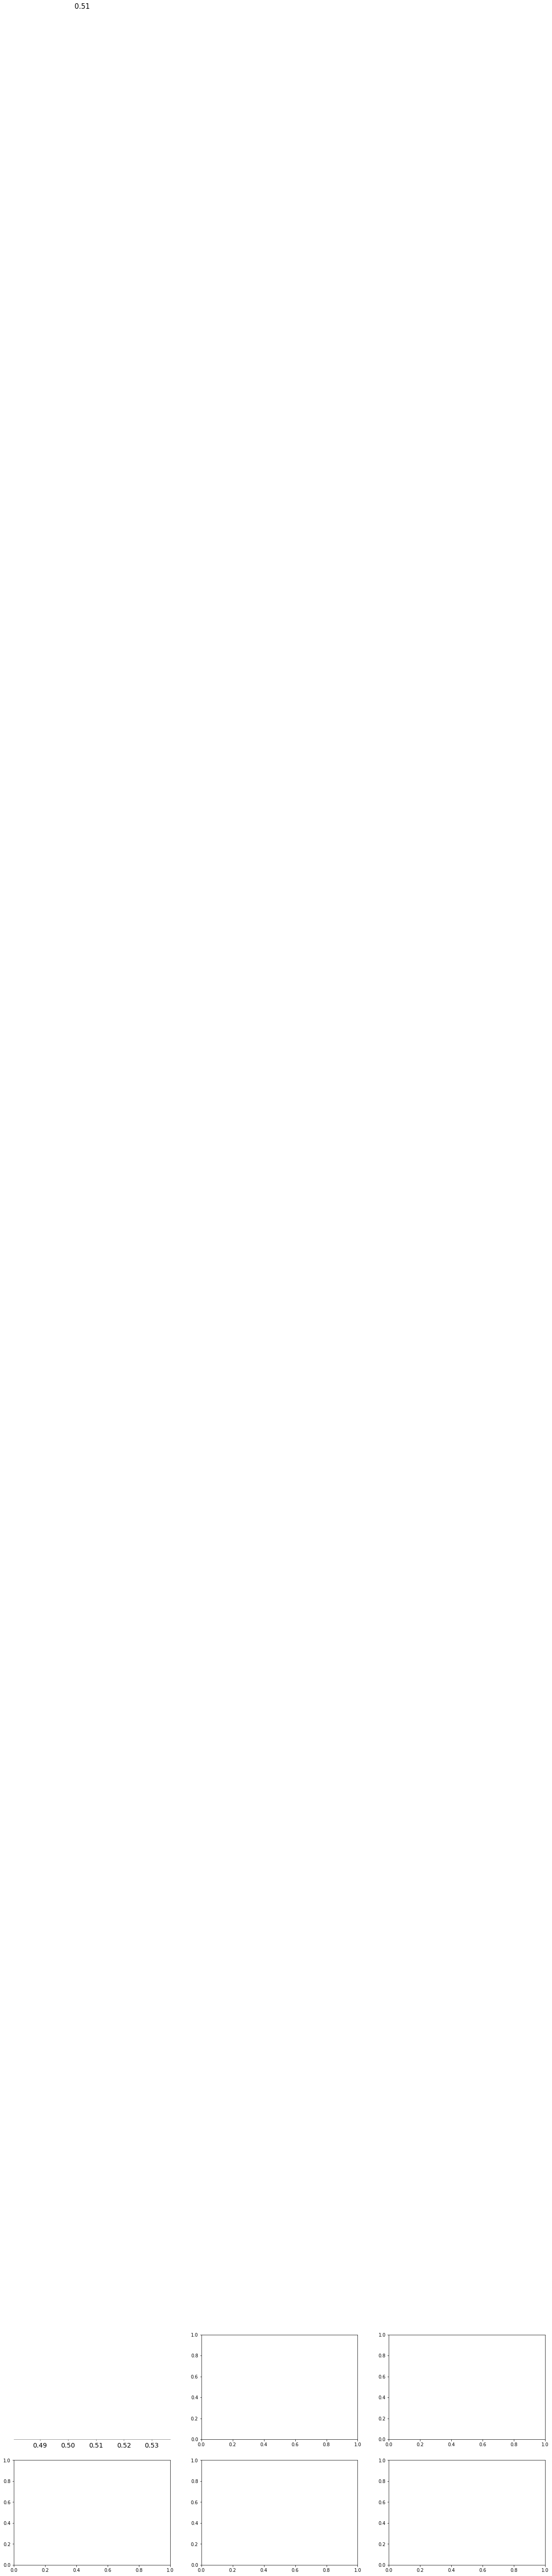

In [130]:
az.plot_posterior(samples_1)

In [ ]:
np.where(np.isnan(samples_1['sigma_y']))